In [1]:
import os
import nltk
import math
import string
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kenredd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#import io
#from google.colab import files
#uploaded = files.upload()

#train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_df = pd.read_csv('train.csv')


#from google.colab import files
#uploaded = files.upload()

valid_df = pd.read_csv('valid.csv')
test_df = pd.read_csv('test.csv')

In [3]:
x_train = train_df['text']
y_train = train_df['stars']
x_valid = valid_df['text']
y_valid = valid_df['stars']
test_df = test_df['text']

## Trial 5: BERT + GloVe (Final model)


In [4]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf
seq_len = 200

In [5]:
# AutoModel for PyTorch, TFAutoModel for TensorFlow
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# I'm using GLoVe word vectors to get pretrained word embeddings
embed_size = 200
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = 'glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file, "r",encoding="utf-8"))

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df['text'].values))

In [ ]:
X_train = tokenizer.texts_to_sequences(train_df['text'].values)
X_valid = tokenizer.texts_to_sequences(valid_df['text'].values)

x_train = pad_sequences(X_train, maxlen = maxlen)
x_valid = pad_sequences(X_valid, maxlen = maxlen)

word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

print(len(missed))

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
inp = Input(shape = (maxlen,),name='inp')
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
max_pool = GlobalMaxPooling1D()(x)

In [ ]:
def prepro(train_df):
    seq_len = 200
    num_samples = len(train_df)

    # initialize empty zero arrays
    Xids = np.zeros((num_samples, seq_len))
    Xmask = np.zeros((num_samples, seq_len))

    # check shape
    Xids.shape

    # initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for i, text in enumerate(train_df['text']):
        tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True,
                                       padding='max_length', add_special_tokens=True,
                                       return_tensors='tf')
        # assign tokenized outputs to respective rows in numpy arrays
        Xids[i, :] = tokens['input_ids']
        Xmask[i, :] = tokens['attention_mask']
    return Xids, Xmask

def one_hot(train_df, num_samples):
    # first extract sentiment column
    arr = train_df['stars'].values

    # we then initialize the zero array
    labels = np.zeros((num_samples, arr.max()))

    # set relevant index for each row to 1 (one-hot encode)
    labels[np.arange(num_samples), arr-1] = 1
    
    return labels

def map_func(input_ids, masks,inp, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks,'inp':inp}, labels

In [ ]:
Xids_train, Xmask_train = prepro(train_df)
Xids_valid, Xmask_valid = prepro(valid_df)

train_one_hot_label = one_hot(train_df, len(train_df))
valid_one_hot_label = one_hot(valid_df, len(valid_df))

In [ ]:
# create the dataset object
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train,x_train, train_one_hot_label))
dataset_valid = tf.data.Dataset.from_tensor_slices((Xids_valid, Xmask_valid,x_valid, valid_one_hot_label))

# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_valid = dataset_valid.map(map_func)

# we will split into batches of 10
batch_size = 10

# shuffle and batch - dropping any remaining samples that don't cleanly
# fit into a batch of 10
dataset_train = dataset_train.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset_valid = dataset_valid.shuffle(10000).batch(batch_size, drop_remainder=True)

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

# convert bert embeddings into 5 output classes
conc = concatenate([max_pool,embeddings])
drop = tf.keras.layers.Dropout(0.5)(conc)
y_data = Dense(5,activation = 'sigmoid')(drop)
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask,inp], outputs=y_data)

In [ ]:
print(model.summary())

In [ ]:
# batchsize=10, adam, 1e-5, epochs=5, decay=1e-3
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    dataset_train,
    validation_data = dataset_valid,
    epochs=5
)

In [18]:
model.save("ken_bert_baseline")

INFO:tensorflow:Assets written to: ken_bert_baseline\assets


INFO:tensorflow:Assets written to: ken_bert_baseline\assets


----------------------------------------------------------------------------------------------------------------------

### The following parts includes model tuning part as well as other addtional models that our group have tried to build 

In [ ]:
# The following optuna is for tuning parameters 
!pip install optuna

import urllib
import warnings
from keras.backend import clear_session
import optuna

def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    dropout_rate = trial.suggest_categorical("dropout_rate", [0.4,0.5,0.6]) 
    activation_last = trial.suggest_categorical("activation_last", ["sigmoid", "softmax"])   
    lnr = trial.suggest_float("lr", 5e-5, 1e-4, log=False)
    decay = trial.suggest_float("decay", 1e-4, 1e-2, log=False)
    batch_size = trial.suggest_categorical("batch_size",[5,10,15])
    EPOCHS = trial.suggest_categorical("epoches",[4,5,6])

    # create the dataset object
    dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train,x_train, train_one_hot_label))
    dataset_valid = tf.data.Dataset.from_tensor_slices((Xids_valid, Xmask_valid,x_valid, valid_one_hot_label))

    # then we use the dataset map method to apply this transformation
    dataset_train = dataset_train.map(map_func)
    dataset_valid = dataset_valid.map(map_func)
    
    dataset_train = dataset_train.shuffle(10000).batch(batch_size, drop_remainder=True)
    dataset_valid = dataset_valid.shuffle(10000).batch(batch_size, drop_remainder=True)   

    inp = Input(shape = (maxlen,),name='inp')
    x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
    x = Bidirectional(LSTM(40, return_sequences=True))(x)
    x = Bidirectional(GRU(40, return_sequences=True))(x)
    max_pool = GlobalMaxPooling1D()(x)
    # two input layers, we ensure layer name variables match to dictionary keys in TF dataset
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

    # we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
    embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

    # convert bert embeddings into 5 output classes
    conc = concatenate([max_pool,embeddings])
    drop = tf.keras.layers.Dropout(dropout_rate)(conc)
    y_data = Dense(5,activation = activation_last)(drop)
    # initialize model
    model = tf.keras.Model(inputs=[input_ids, mask,inp], outputs=y_data)

    optimizer = tf.keras.optimizers.Adam(lr=lnr, decay = decay)


    model.compile(optimizer= optimizer , 
                loss=trial.suggest_categorical("loss", ["categorical_crossentropy","binary_crossentropy"]), 
                metrics=["accuracy"])

    # result 
    model.fit(
      dataset_train,
      validation_data = dataset_valid,
      epochs=EPOCHS,
      verbose=1,
    )    

    score = model.evaluate(dataset_valid, verbose=1)
    return score[1]
    
    
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=None)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [11]:
# create the dataset object
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train,x_train, train_one_hot_label))
dataset_valid = tf.data.Dataset.from_tensor_slices((Xids_valid, Xmask_valid,x_valid, valid_one_hot_label))

# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_valid = dataset_valid.map(map_func)

# we will split into batches of 5
batch_size = 5

# shuffle and batch - dropping any remaining samples that don't cleanly
# fit into a batch of 5
dataset_train = dataset_train.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset_valid = dataset_valid.shuffle(10000).batch(batch_size, drop_remainder=True)

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

# convert bert embeddings into 5 output classes
conc = concatenate([max_pool,embeddings])
drop = tf.keras.layers.Dropout(0.4)(conc)
y_data = Dense(5,activation = 'sigmoid')(drop)
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask,inp], outputs=y_data)

In [12]:
# Train the model using the optimized parameters
optimizer = tf.keras.optimizers.Adam(lr=7.239845056882018e-05, decay=0.006044177522958287)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    dataset_train,
    validation_data = dataset_valid,
    epochs=5
)

Epoch 1/5
2000/2000 [==============================] - 520s 253ms/step - loss: 0.3804 - accuracy: 0.5121 - val_loss: 0.2883 - val_accuracy: 0.6435
Epoch 2/5
2000/2000 [==============================] - 502s 251ms/step - loss: 0.2583 - accuracy: 0.7011 - val_loss: 0.2947 - val_accuracy: 0.6525
Epoch 3/5
2000/2000 [==============================] - 499s 250ms/step - loss: 0.2197 - accuracy: 0.7648 - val_loss: 0.3032 - val_accuracy: 0.6640
Epoch 4/5
2000/2000 [==============================] - 500s 250ms/step - loss: 0.1860 - accuracy: 0.8176 - val_loss: 0.3271 - val_accuracy: 0.6545
Epoch 5/5
2000/2000 [==============================] - 500s 250ms/step - loss: 0.1631 - accuracy: 0.8473 - val_loss: 0.3453 - val_accuracy: 0.6475


In [13]:
model.save('ken_bert_tuned')

INFO:tensorflow:Assets written to: ken_bert_tuned\assets


INFO:tensorflow:Assets written to: ken_bert_tuned\assets


## Trial 4: GloVe with LSTM and GRU 

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
# I'm using GLoVe word vectors to get pretrained word embeddings
embed_size = 200
# max number of unique words 
max_features = 18000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = 'glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file, "r",encoding="utf-8"))

In [16]:
train_df_klg = pd.get_dummies(train_df,columns=['stars'])
valid_df_klg = pd.get_dummies(valid_df,columns=['stars'])

In [17]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
# Splitting off my y variable
y_t = train_df_klg[class_names].values
y_v = valid_df_klg[class_names].values

In [18]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df_klg['text'].values))
X_train_klg = tokenizer.texts_to_sequences(train_df_klg['text'].values)
X_valid_klg = tokenizer.texts_to_sequences(valid_df_klg['text'].values)
x_train_klg = pad_sequences(X_train_klg, maxlen = maxlen)
x_valid_klg = pad_sequences(X_valid_klg, maxlen = maxlen)

In [19]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [20]:
print(len(missed))

1974


In [21]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
os.makedirs("models", exist_ok=True)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath=os.path.join("models", "weights.hdf5"))
model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics = ['accuracy'])

In [22]:
model.fit(x_train_klg, y_t, batch_size = 10, epochs = 15, validation_split = 0.1,
          callbacks=[checkpoint])

Epoch 1/15
900/900 [==============================] - 34s 32ms/step - loss: 0.4677 - accuracy: 0.3573 - val_loss: 0.3677 - val_accuracy: 0.5240
Epoch 2/15
900/900 [==============================] - 28s 31ms/step - loss: 0.3617 - accuracy: 0.5511 - val_loss: 0.3405 - val_accuracy: 0.5720
Epoch 3/15
900/900 [==============================] - 28s 31ms/step - loss: 0.3350 - accuracy: 0.5840 - val_loss: 0.3222 - val_accuracy: 0.5990
Epoch 4/15
900/900 [==============================] - 28s 31ms/step - loss: 0.3068 - accuracy: 0.6311 - val_loss: 0.3167 - val_accuracy: 0.6080
Epoch 5/15
900/900 [==============================] - 28s 31ms/step - loss: 0.2949 - accuracy: 0.6446 - val_loss: 0.3129 - val_accuracy: 0.6010
Epoch 6/15
900/900 [==============================] - 28s 31ms/step - loss: 0.2857 - accuracy: 0.6658 - val_loss: 0.3197 - val_accuracy: 0.6120
Epoch 7/15
900/900 [==============================] - 28s 31ms/step - loss: 0.2783 - accuracy: 0.6720 - val_loss: 0.3128 - val_accuracy:

In [23]:
y_valid = model.predict([x_valid_klg], batch_size=100, verbose = 1)

20/20 [==============================] - 1s 16ms/step


In [24]:
print(y_valid)

[[1.1056866e-03 7.1265823e-03 7.5080812e-02 7.6653779e-01 6.5441757e-02]
 [7.5412229e-02 4.6692982e-01 3.9374492e-01 4.0903399e-03 5.7738961e-04]
 [7.7472039e-02 4.5488209e-01 3.9793921e-01 2.1814229e-02 1.5919737e-03]
 ...
 [2.2404031e-03 4.6889094e-04 6.7676352e-03 4.3673515e-02 9.5855248e-01]
 [7.1982548e-05 5.7223872e-03 4.4441119e-01 5.0169557e-01 2.6763079e-03]
 [1.8207401e-04 1.8999949e-03 4.6348114e-02 9.5612276e-01 1.6049556e-02]]


In [25]:
model.evaluate(x_valid_klg, y_v, verbose = 1, batch_size=100)

20/20 [==============================] - 2s 17ms/step - loss: 0.3658 - accuracy: 0.6110


[0.36575356125831604, 0.6110000014305115]

In [26]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
v = metrics.classification_report(np.argmax(y_v, axis = 1),np.argmax(y_valid, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       517
           1       0.38      0.34      0.36       278
           2       0.50      0.43      0.46       344
           3       0.51      0.62      0.56       427
           4       0.74      0.69      0.72       434

    accuracy                           0.61      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.61      0.61      0.61      2000



In [27]:
model.save('ken_kaggle_lstm_gru')

INFO:tensorflow:Assets written to: ken_kaggle_lstm_gru\assets


INFO:tensorflow:Assets written to: ken_kaggle_lstm_gru\assets


## Trial 2: Bert (Without GloVe embedding layer)

In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf
seq_len = 500

In [2]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('valid.csv')

In [3]:
train_df = train_df[['text', 'stars']]
valid_df = valid_df[['text', 'stars']]

In [1]:
# pip install transformers

In [7]:
# AutoModel for PyTorch, TFAutoModel for TensorFlow
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
def prepro(train_df):
    seq_len = 500
    num_samples = len(train_df)

    # initialize empty zero arrays
    Xids = np.zeros((num_samples, seq_len))
    Xmask = np.zeros((num_samples, seq_len))

    # check shape
    Xids.shape

    # initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    for i, text in enumerate(train_df['text']):
        tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True,
                                       padding='max_length', add_special_tokens=True,
                                       return_tensors='tf')
        # assign tokenized outputs to respective rows in numpy arrays
        Xids[i, :] = tokens['input_ids']
        Xmask[i, :] = tokens['attention_mask']
    return Xids, Xmask

def one_hot(train_df, num_samples):
    # first extract sentiment column
    arr = train_df['stars'].values

    # we then initialize the zero array
    labels = np.zeros((num_samples, arr.max()))

    # set relevant index for each row to 1 (one-hot encode)
    labels[np.arange(num_samples), arr-1] = 1
    
    return labels

def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [9]:
# Input_id, attention_mask
Xids_train, Xmask_train = prepro(train_df)
Xids_valid, Xmask_valid = prepro(valid_df)

# One-hot labels
train_one_hot_label = one_hot(train_df, len(train_df))
valid_one_hot_label = one_hot(valid_df, len(valid_df))

In [16]:
# create the dataset object
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, train_one_hot_label))
dataset_valid = tf.data.Dataset.from_tensor_slices((Xids_valid, Xmask_valid, valid_one_hot_label))

# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_valid = dataset_valid.map(map_func)

# we will split into batches of 2
batch_size = 2

# shuffle and batch - dropping any remaining samples that don't cleanly
# fit into a batch of 2
dataset_train = dataset_train.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset_valid = dataset_valid.shuffle(10000).batch(batch_size, drop_remainder=True)

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
y = tf.keras.layers.Dropout(0.4)(x)
z = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(y)

# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=z)

In [17]:
# batchsize=2, adam, 1e-5, epochs=5, decay=1e-3
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    dataset_train,
    validation_data = dataset_valid,
    epochs=5
)

Epoch 1/5
5000/5000 [==============================] - 1264s 251ms/step - loss: 1.1911 - accuracy: 0.4909 - val_loss: 0.8011 - val_accuracy: 0.6520
Epoch 2/5
5000/5000 [==============================] - 1253s 251ms/step - loss: 0.7699 - accuracy: 0.6791 - val_loss: 0.7934 - val_accuracy: 0.6570
Epoch 3/5
5000/5000 [==============================] - 1255s 251ms/step - loss: 0.7104 - accuracy: 0.7052 - val_loss: 0.7985 - val_accuracy: 0.6570
Epoch 4/5
5000/5000 [==============================] - 1255s 251ms/step - loss: 0.6472 - accuracy: 0.7329 - val_loss: 0.8159 - val_accuracy: 0.6615
Epoch 5/5
5000/5000 [==============================] - 1255s 251ms/step - loss: 0.6055 - accuracy: 0.7630 - val_loss: 0.8269 - val_accuracy: 0.6600


In [18]:
model.save('Carrie_Bert_wo_Glove')

INFO:tensorflow:Assets written to: Carrie_Bert_wo_Glove\assets


INFO:tensorflow:Assets written to: Carrie_Bert_wo_Glove\assets


## RNN, LSTM, BiLSTM and GRU without EMBEDDING LAYER

In [19]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('valid.csv')

In [20]:
x_train = train_df['text']
y_train = train_df['stars']
x_valid = valid_df['text']
y_valid = valid_df['stars']

In [9]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(text)
    return new_words


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

In [22]:
x_train_tok = x_train.map(tokenize).map(filter_stopwords).map(stem)
x_valid_tok = x_valid.map(tokenize).map(filter_stopwords).map(stem)

RNN, LSTM, BiLSTM and GRU without EMBEDDING LAYER

In [23]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [25]:
from collections import Counter
from itertools import chain

min_freq = 3
x_train_feats = x_train_tok
x_valid_feats = x_valid_tok

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(x_train_feats),
    min_freq=min_freq)

Size of features: 8903


In [29]:
max_len = 50

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
x_train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in x_train_feats])
x_valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in x_valid_feats])

# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
x_train_label_matrix = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
x_valid_label_matrix = keras.utils.to_categorical(y_valid-1, num_classes=num_classes)

In [30]:
x_train_feats_matrix

array([[  32,  982,   83, ...,    0,    0,    0],
       [  19,   18,   25, ...,    7,   20,  640],
       [   2,  165,  304, ...,    0,    0,    0],
       ...,
       [   2,   43,   19, ..., 1568,  721,    3],
       [ 667,  667,  667, ...,    0,    0,    0],
       [  84,  194,  213, ...,    0,    0,    0]], dtype=int64)

In [31]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="rnn", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(x_train_feats_matrix, x_train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(x_train_feats_matrix, x_train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(x_valid_feats_matrix, x_valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 13ms/step - loss: 2.1558 - accuracy: 0.4195
training loss: 0.511573076248169 training accuracy 0.8569999933242798
test loss: 2.155839204788208 test accuracy 0.4194999933242798


In [32]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
lstm_history = model.fit(x_train_feats_matrix, x_train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(x_train_feats_matrix, x_train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(x_valid_feats_matrix, x_valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 4ms/step - loss: 1.4494 - accuracy: 0.5110
training loss: 1.2200677394866943 training accuracy 0.630299985408783
test loss: 1.449431300163269 test accuracy 0.5109999775886536


In [33]:
model.save('Alex_LSTM_wo_embedding')

INFO:tensorflow:Assets written to: Alex_LSTM_wo_embedding\assets


INFO:tensorflow:Assets written to: Alex_LSTM_wo_embedding\assets


In [34]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
gru_history = model.fit(x_train_feats_matrix, x_train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(x_train_feats_matrix, x_train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(x_valid_feats_matrix, x_valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 4ms/step - loss: 1.7853 - accuracy: 0.4610
training loss: 0.5504740476608276 training accuracy 0.8521000146865845
test loss: 1.7852778434753418 test accuracy 0.460999995470047


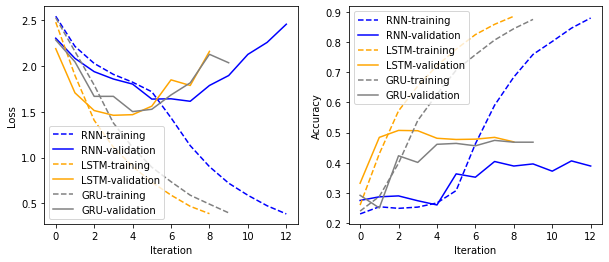

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rnn_history.history["loss"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_loss"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["loss"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(rnn_history.history["accuracy"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_accuracy"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
bilstm_history = model.fit(x_train_feats_matrix, x_train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(x_train_feats_matrix, x_train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(x_valid_feats_matrix, x_valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 5ms/step - loss: 1.7367 - accuracy: 0.5040
training loss: 1.642546534538269 training accuracy 0.6298999786376953
test loss: 1.7366782426834106 test accuracy 0.5040000081062317


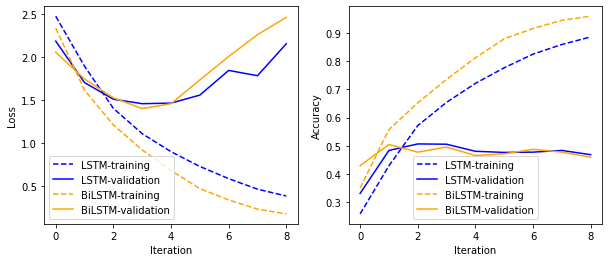

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

BiLSTM with trained Embedding Layer

In [38]:
x_train.to_csv('train.txt', header=False, index=False, sep=' ', mode='a')

In [39]:
!fasttext-win64-latest-Release\Release\fasttext.exe skipgram -input data\reviews.txt -output models\word2vec -dim 100 -minCount 3 -epoch 10

In [40]:
embedding_matrix = np.zeros((len(feats_dict), 100), dtype=np.float32)
with open("models/word2vec.vec", "r",encoding="utf-8") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 74561 word dimension: 100


In [41]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
word2vec_bilstm_history = model.fit(x_train_feats_matrix, x_train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(x_train_feats_matrix, x_train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(x_valid_feats_matrix, x_valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 6ms/step - loss: 1.3647 - accuracy: 0.5050
training loss: 1.2651277780532837 training accuracy 0.5516999959945679
test loss: 1.3646959066390991 test accuracy 0.5049999952316284


In [42]:
model.save('Alex_w2v_BiLSTM')

INFO:tensorflow:Assets written to: Alex_w2v_BiLSTM\assets


INFO:tensorflow:Assets written to: Alex_w2v_BiLSTM\assets


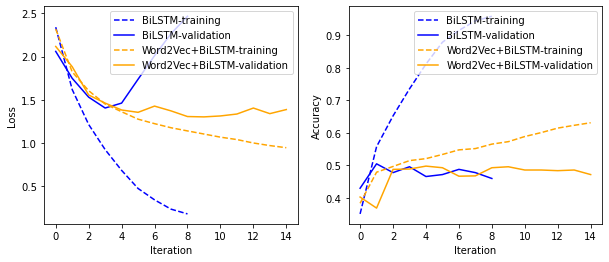

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["loss"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_loss"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["accuracy"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_accuracy"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Trial 1: XGBoost with TFIDF

In [44]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
xgb_pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('xgb', xgb.XGBClassifier(max_depth=50, 
            n_estimators=80, 
            learning_rate=0.1, 
            colsample_bytree=.7, 
            gamma=0, 
            reg_alpha=4, 
            objective='multi:softmax', 
            eta=0.3, 
            silent=1, 
            subsample=0.8
        )),
    ]
)
print(xgb_pipeline)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, eta=0.3, gamma=0,
                               gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=50,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=80,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softmax', random_state=None,
                               reg_alpha=4, reg_lambda=None,
                               scale_pos_weight=None, silent=1, subsample=0.8,
                               tree_method=None, validate_parameters=None,
   

In [46]:
model = xgb_pipeline.fit(x_train, y_train)

C:\Users\Alex\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
y_pred = xgb_pipeline.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.68      0.86      0.76       517
           2       0.36      0.15      0.22       278
           3       0.44      0.47      0.45       344
           4       0.48      0.49      0.49       427
           5       0.64      0.63      0.63       434

    accuracy                           0.57      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.54      0.57      0.55      2000




[[445  22  24  12  14]
 [109  43  83  30  13]
 [ 51  36 160  76  21]
 [ 23  16  73 211 104]
 [ 25   3  20 114 272]]
accuracy 0.5655


## Trial 3: CNN + gridsearchcv

In [5]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["user_id"], df["text"], df["stars"]

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["stars"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["user_id", "stars"]
    df.to_csv(file_name, index=False)

In [49]:
train_file = "train.csv"
valid_file = "valid.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, test_labels = load_data(valid_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]

# build the feature list
train_feats = list()
for i in range(len(train_ids)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
test_feats = list()
for i in range(len(test_ids)):
    test_feats.append(
        test_stemmed[i] + test_2_gram[i] + test_3_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

Size of features: 28465


In [50]:
def load_data1(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

train_df = load_data1('train')
valid_df = load_data1('valid')

X_train = train_df['text']
Y_train = train_df['stars']

X_test = valid_df['text']
Y_test = valid_df['stars']

select [text, stars] columns from the train split
succeed!
select [text, stars] columns from the valid split
succeed!


In [51]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


def build_classifier(input_size, output_size,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     learning_rate=0.1,
                     metric="accuracy"):
    
    model = Sequential()
    
    # the projection layer
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    bias_initializer="zeros"))

    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    return model


np.random.seed(0)
tf.random.set_seed(0)

#Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.
def create_model():
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes,)
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define grid search parameter 
batch_size = [5, 20,100,300]
epochs = [2, 5, 20, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_feats_matrix, train_label_matrix,)


# grid searching result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.577200 using {'batch_size': 20, 'epochs': 50}
0.559000 (0.008503) with: {'batch_size': 5, 'epochs': 2}
0.573300 (0.006120) with: {'batch_size': 5, 'epochs': 5}
0.571500 (0.006395) with: {'batch_size': 5, 'epochs': 20}
0.564900 (0.005152) with: {'batch_size': 5, 'epochs': 50}
0.561000 (0.006269) with: {'batch_size': 5, 'epochs': 100}
0.520100 (0.013059) with: {'batch_size': 20, 'epochs': 2}
0.547700 (0.005335) with: {'batch_size': 20, 'epochs': 5}
0.574300 (0.006577) with: {'batch_size': 20, 'epochs': 20}
0.577200 (0.007366) with: {'batch_size': 20, 'epochs': 50}
0.572300 (0.007434) with: {'batch_size': 20, 'epochs': 100}
0.420400 (0.013317) with: {'batch_size': 100, 'epochs': 2}
0.492100 (0.008399) with: {'batch_size': 100, 'epochs': 5}
0.544700 (0.008177) with: {'batch_size': 100, 'epochs': 20}
0.564400 (0.007283) with: {'batch_size': 100, 'epochs': 50}
0.574000 (0.006173) with: {'batch_size': 100, 'epochs': 100}
0.341400 (0.003569) with: {'batch_size': 300, 'epochs': 2}
0.403

In [53]:
e = grid_result.best_params_["epochs"]

In [54]:
b = grid_result.best_params_["batch_size"]

In [55]:
def create_model(optimizer='SGD'):
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes,optimizer=optimizer)
    return model

np.random.seed(0)
tf.random.set_seed(0)

#create the model with the best epoch and batch size found in last step
model = KerasClassifier(build_fn=create_model, epochs=grid_result.best_params_["epochs"], batch_size=grid_result.best_params_["batch_size"], verbose=0)

# difine grid search parameter 
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_feats_matrix, train_label_matrix,)

# grid searching result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.577200 using {'optimizer': 'SGD'}
0.577200 (0.006585) with: {'optimizer': 'SGD'}
0.544800 (0.004400) with: {'optimizer': 'RMSprop'}
0.564100 (0.006689) with: {'optimizer': 'Adagrad'}
0.383800 (0.012832) with: {'optimizer': 'Adadelta'}
0.536700 (0.003906) with: {'optimizer': 'Adam'}
0.571400 (0.005342) with: {'optimizer': 'Adamax'}
0.537800 (0.003970) with: {'optimizer': 'Nadam'}


In [56]:
o = grid_result.best_params_["optimizer"]

In [59]:
model = create_model()
model.fit(train_feats_matrix, train_label_matrix, epochs=50, batch_size=20, verbose=0)

In [60]:
model.save('Nicky_GC')

INFO:tensorflow:Assets written to: Nicky_GC\assets


INFO:tensorflow:Assets written to: Nicky_GC\assets


CNN

In [3]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer='SGD',
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param kernel_sizes: the kernel sizes of convolutional layers, type: list
    :param num_filters: the number of filters for each kernel, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param padding: the padding method in convolutional layers, type: str
    :param strides: the strides in convolutional layers, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a CNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # convolutional layers document: https://keras.io/layers/convolutional
    # pooling layers document: https://keras.io/layers/pooling/
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)
    
    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adagrad":
        optmizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == "Adadelta":
        optmizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == "Adamax":
        optmizer = keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer == "Nadam":
        optmizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [10]:
train_file = "data_2021_spring/train.csv"
valid_file = "data_2021_spring/valid.csv"

min_freq = 3

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, test_labels = load_data(valid_file)

# extract features
train_lower = [lower(text) for text in train_texts]
test_lower = [lower(text) for text in test_texts]

train_tokens = [tokenize(lower) for lower in train_lower]
test_tokens = [tokenize(lower) for lower in test_lower]

train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]

# build the feature list
train_feats = list()
for i in range(len(train_ids)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
test_feats = list()
for i in range(len(test_ids)):
    test_feats.append(
        test_stemmed[i] + test_2_gram[i] + test_3_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

max_len = 150

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

Size of features: 65948


In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Flatten, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding

max_len = 150
e = 50
b = 20

os.makedirs("models", exist_ok=True)
model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu",
                  dropout_rate=0.5, l2_reg=0.005, batch_norm=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

np.random.seed(0)
tf.random.set_seed(0)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=e, batch_size=b, verbose=0,
                    callbacks=[checkpointer])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=b)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=b)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

100/100 [==============================] - 1s 5ms/step - loss: 1.0845 - accuracy: 0.5805
training loss: 0.7670180201530457 training accuracy 0.7401999831199646
test loss: 1.084506869316101 test accuracy 0.5805000066757202


In [13]:
model.save('Nicky_CNN')

INFO:tensorflow:Assets written to: Nicky_CNN\assets


# Prediction (BERT + GloVe)

In [7]:
test_df = pd.read_csv('test.csv')
valid_df = pd.read_csv('valid.csv')

In [10]:
X_test = tokenizer.texts_to_sequences(test_df['text'].values)
x_test = pad_sequences(X_test, maxlen = maxlen)
X_valid = tokenizer.texts_to_sequences(valid_df['text'].values)
x_valid = pad_sequences(X_valid, maxlen = maxlen)

In [11]:
print(x_test.shape)
print(x_valid.shape)

(2000, 200)
(2000, 200)


In [13]:
x_test_text = test_df['text']
x_test_text = x_test_text.tolist()
x_valid_text = valid_df['text']
x_valid_text = x_valid_text.tolist()

In [14]:
model = tf.keras.models.load_model('ken_bert_baseline')

In [15]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prep_data(text,glove):
    tokens = tokenizer.encode_plus(text, max_length = 200,
                                  truncation=True, padding = 'max_length',
                                  add_special_tokens=True, return_token_type_id=False,
                                  return_tensors='tf')
    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float64),
        'inp': tf.cast(glove, tf.float64)
    }

In [17]:
valid_data =[]
for i in range(len(x_valid)):
    test = prep_data(x_valid_text[i],[x_valid[i]])
    y_pred = model.predict(test)
    valid_data.append(np.argmax(y_pred))

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

In [18]:
print(valid_data)

[2, 1, 1, 2, 0, 0, 3, 0, 4, 2, 4, 3, 4, 2, 2, 2, 4, 1, 2, 1, 1, 3, 4, 3, 4, 0, 4, 0, 2, 2, 4, 4, 4, 3, 1, 0, 2, 2, 0, 3, 4, 1, 0, 2, 4, 0, 0, 0, 4, 2, 0, 4, 3, 1, 3, 1, 3, 3, 4, 1, 3, 2, 2, 4, 4, 4, 1, 1, 2, 4, 3, 4, 1, 3, 2, 2, 1, 1, 2, 3, 4, 3, 1, 4, 0, 2, 1, 1, 0, 0, 4, 2, 0, 2, 2, 1, 0, 0, 2, 0, 4, 0, 4, 1, 2, 4, 0, 1, 0, 3, 2, 0, 4, 0, 4, 4, 2, 3, 3, 0, 2, 3, 4, 1, 0, 2, 3, 4, 2, 1, 0, 2, 1, 2, 2, 0, 0, 3, 4, 4, 2, 1, 2, 2, 3, 0, 0, 0, 0, 4, 1, 4, 4, 4, 2, 1, 4, 0, 0, 1, 2, 4, 4, 3, 1, 0, 3, 3, 3, 0, 4, 2, 3, 1, 4, 3, 0, 1, 3, 0, 0, 1, 0, 2, 3, 0, 0, 4, 4, 3, 0, 0, 0, 0, 4, 3, 4, 2, 4, 0, 4, 3, 4, 0, 2, 1, 0, 0, 0, 0, 2, 4, 4, 0, 0, 1, 1, 3, 0, 4, 3, 3, 2, 2, 4, 0, 4, 2, 2, 4, 4, 3, 4, 1, 3, 4, 3, 2, 4, 3, 0, 3, 2, 0, 2, 0, 1, 4, 4, 0, 0, 4, 2, 0, 4, 2, 3, 0, 3, 3, 4, 3, 0, 0, 3, 3, 0, 4, 3, 0, 0, 2, 4, 0, 0, 2, 1, 4, 2, 1, 2, 0, 3, 0, 2, 4, 2, 2, 4, 4, 2, 3, 0, 0, 4, 4, 2, 0, 4, 4, 0, 2, 4, 0, 4, 4, 4, 3, 0, 4, 4, 4, 2, 3, 2, 2, 0, 2, 1, 1, 3, 1, 0, 1, 2, 0, 3, 2, 0, 4, 3, 2, 3, 

In [19]:
valid_real = valid_df['stars'].tolist()
print(valid_real)

[5, 3, 2, 4, 1, 1, 4, 1, 5, 4, 5, 4, 5, 3, 4, 3, 1, 3, 4, 3, 2, 3, 5, 3, 5, 1, 5, 1, 4, 3, 5, 4, 4, 2, 2, 1, 3, 1, 1, 4, 5, 1, 1, 3, 4, 2, 1, 3, 5, 3, 1, 4, 4, 3, 5, 3, 4, 4, 5, 2, 4, 2, 4, 5, 4, 5, 3, 2, 4, 5, 4, 4, 2, 3, 3, 4, 2, 3, 4, 4, 5, 4, 2, 4, 2, 2, 1, 2, 4, 1, 5, 3, 1, 2, 4, 3, 1, 1, 2, 1, 5, 1, 4, 1, 3, 5, 1, 2, 1, 4, 3, 1, 5, 2, 4, 5, 3, 3, 4, 1, 5, 5, 4, 3, 2, 2, 3, 5, 3, 1, 2, 3, 3, 3, 3, 1, 1, 4, 5, 5, 1, 1, 4, 3, 4, 1, 1, 1, 1, 5, 2, 4, 5, 4, 4, 2, 4, 1, 1, 2, 3, 5, 4, 4, 1, 2, 4, 5, 4, 1, 5, 2, 5, 2, 5, 3, 1, 1, 4, 1, 1, 1, 1, 3, 5, 1, 1, 5, 5, 4, 1, 1, 1, 1, 4, 4, 5, 2, 5, 1, 5, 4, 4, 1, 1, 4, 1, 2, 1, 1, 3, 5, 5, 1, 1, 1, 1, 5, 1, 5, 4, 5, 3, 4, 4, 1, 5, 4, 3, 4, 5, 4, 5, 2, 4, 5, 4, 4, 5, 4, 2, 5, 3, 1, 3, 1, 2, 5, 5, 1, 1, 4, 4, 1, 5, 3, 3, 2, 4, 4, 5, 4, 1, 1, 3, 4, 2, 5, 5, 1, 1, 3, 5, 2, 1, 1, 2, 5, 2, 3, 3, 2, 4, 1, 2, 5, 3, 3, 5, 4, 3, 4, 1, 1, 5, 4, 3, 1, 5, 5, 1, 4, 5, 1, 5, 5, 5, 4, 1, 5, 4, 5, 5, 4, 3, 3, 1, 3, 3, 1, 3, 2, 1, 2, 3, 1, 3, 2, 1, 5, 4, 3, 4, 

In [22]:
sum_valid =0
for i in range(len(valid_real)):
    if valid_real[i]==valid_data[i]+1:
        sum_valid+=1
print(float(sum_valid)/float(len(valid_real)))

0.6405


In [23]:
test_data = []
for i in range(len(x_test)):
    test = prep_data(x_test_text[i],[x_test[i]])
    y_pred = model.predict(test)
    test_data.append(np.argmax(y_pred))

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword arguments {'return_token_type_id': False} not recognized.
Keyword ar

In [27]:
backup = test_data
for i in range(len(test_data)):
    test_data[i]+=1
print(test_data)

[1, 5, 3, 1, 1, 5, 2, 4, 4, 2, 2, 4, 3, 5, 4, 5, 3, 4, 1, 1, 5, 1, 1, 5, 1, 2, 5, 3, 2, 4, 1, 1, 1, 1, 5, 5, 4, 1, 5, 5, 1, 1, 3, 3, 4, 4, 1, 1, 5, 4, 4, 5, 5, 4, 1, 2, 3, 5, 4, 5, 3, 3, 5, 2, 1, 5, 2, 3, 4, 2, 3, 1, 2, 2, 1, 1, 1, 2, 3, 1, 2, 3, 5, 5, 5, 5, 4, 4, 4, 3, 4, 1, 1, 5, 4, 4, 5, 3, 5, 4, 4, 2, 1, 1, 1, 4, 4, 2, 5, 3, 1, 4, 3, 1, 4, 2, 5, 5, 5, 3, 1, 5, 5, 5, 5, 1, 1, 3, 4, 5, 3, 3, 2, 5, 2, 3, 2, 5, 5, 5, 5, 3, 4, 1, 1, 1, 5, 3, 3, 1, 2, 4, 1, 4, 1, 3, 5, 3, 5, 4, 5, 4, 3, 3, 2, 2, 4, 5, 5, 3, 3, 5, 3, 2, 2, 4, 4, 5, 3, 2, 5, 1, 1, 3, 2, 4, 4, 1, 3, 4, 4, 1, 5, 5, 4, 5, 2, 3, 4, 3, 3, 5, 1, 4, 5, 3, 5, 4, 3, 1, 4, 5, 3, 2, 5, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 3, 4, 1, 1, 2, 4, 4, 3, 5, 2, 2, 1, 3, 5, 1, 3, 5, 5, 3, 1, 1, 1, 2, 3, 2, 4, 1, 3, 2, 3, 4, 3, 3, 5, 3, 1, 2, 2, 4, 5, 1, 5, 4, 2, 1, 5, 4, 1, 1, 5, 1, 5, 3, 5, 4, 5, 3, 1, 1, 3, 1, 1, 2, 5, 4, 5, 3, 4, 3, 5, 2, 1, 1, 4, 2, 3, 1, 2, 1, 3, 3, 4, 1, 5, 3, 2, 3, 1, 4, 5, 5, 5, 5, 2, 5, 4, 4, 5, 3, 4, 4, 4, 4, 3, 5, 5, 5, 1, 

In [28]:
print(len(test_data))


2000


In [29]:
pred_df = pd.DataFrame({'stars': test_data, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)